In [1]:
# SW:
#baseline: 90 min in standby mode
#experiment: 15 min interval, video playback of max/medium/min brightness for two rounds
# HW:
#baseline: 90 min in standby mode
#experiment: 15 min interval, video playback of max/medium/min brightness for two rounds

In [2]:
import sys
import logging
from uuid import UUID

import arrow
import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import public_data


logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)


android_id = "248d8da2-9288-41b2-a0fe-29c1f2f01932"

In [3]:
# pull data from the server 
server_url = 'https://e-mission.eecs.berkeley.edu'

#overall
start_ts = arrow.get('2016-10-17 14:04:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-17 22:22:00', 'YYYY-MM-DD HH:mm:ss').timestamp

phone_ids = [android_id]

public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

Data loaded to local server!


In [4]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
android_ts = esta.TimeSeries.get_time_series(UUID(android_id))

#time query specification
#overall
start_ts = arrow.get('2016-10-17 14:04:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts = arrow.get('2016-10-17 22:22:00', 'YYYY-MM-DD HH:mm:ss').timestamp

time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)
android_battery_df = android_ts.get_data_df("background/battery", time_range)



# baseline brightness
start_ts0 = arrow.get('2016-10-17 15:44:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts0 = arrow.get('2016-10-17 17:44:00', 'YYYY-MM-DD HH:mm:ss').timestamp

# video playback of various brightness
start_ts1 = arrow.get('2016-10-17 18:55:00', 'YYYY-MM-DD HH:mm:ss').timestamp
end_ts1 = arrow.get('2016-10-17 20:36:00', 'YYYY-MM-DD HH:mm:ss').timestamp


time_list = [(start_ts0, end_ts0), (start_ts1, end_ts1)]
time_range_list = map(lambda t: estt.TimeQuery("metadata.write_ts", t[0], t[1]), time_list)
android_battery_df_list = map(lambda t: android_ts.get_data_df("background/battery", t), time_range_list)

In [5]:
import numpy as np

android_xnew = np.arange(start_ts, end_ts, 30) # 30 seconds

android_xnew_list = map(lambda t: np.arange(t[0], t[1], 30), time_list)

In [6]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [7]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [8]:
android_battery_interp_df = get_interpolated_df(android_battery_df, android_xnew)

android_battery_interp_df_list = map(lambda i: get_interpolated_df(android_battery_df_list[i], android_xnew_list[i]), range(len(android_xnew_list)))

In [10]:
label = ['baseline', 'video']
style = ['ob', 'og', 'or', 'oc']
style_interp = ['b', 'g', 'r', 'c']

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

In [12]:
from scipy import stats

slope_list=[]
print "From linear model fitting ..." 
for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-start_ts)/3600.0
    df['m'] = df.hr*60.0
    notnull = df.battery_level_pct.notnull()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.m[notnull], df.battery_level_pct[notnull])
    print "android %d: " % (i+1)  + "slope="+str(slope) + " %/min  std_err="+str(std_err)
    slope_list.append(slope)

#print "average slope=" + str(sum(slope_list)/len(slope_list)) + " %/min  std dev=" + str(np.std(slope_list))
print "\n avg sw experiment/baseline ratio = " + str(slope_list[1]/slope_list[0])

From linear model fitting ...
android 1: slope=-0.0431561119316 %/min  std_err=0.000403069453928
android 2: slope=-0.493857012758 %/min  std_err=0.000405542140348

 avg sw experiment/baseline ratio = 11.4435010628


df0
                           fmt_time  battery_level_pct
0  2016-10-17T15:57:57.854000+00:00                 98
1  2016-10-17T16:37:01.889000+00:00                 96
2  2016-10-17T17:08:28.272000+00:00                 95
df1
                           fmt_time  battery_level_pct
0  2016-10-17T18:58:39.308000+00:00                 99
1  2016-10-17T19:52:07.887000+00:00                 73
2  2016-10-17T20:25:30.905000+00:00                 56


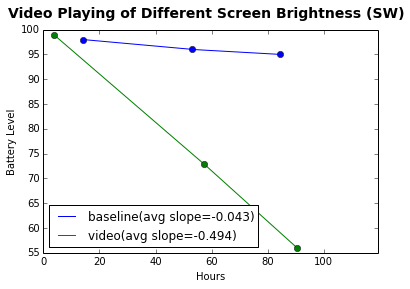

In [58]:
#Android: With interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1)
iaxes = iaxes2d

ifig.suptitle('Video Playing of Different Screen Brightness (SW)', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-time_list[i][0])/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='m', y='battery_level_pct', style=style_interp[i], label=label[i]+"(avg slope=%s)" % round(slope_list[i], 3), ax=iaxes, legend=True)


for i, df in enumerate(android_battery_df_list):
    print "df" +str(i)
    print df[['fmt_time', 'battery_level_pct']]
    df['hr'] = (df.ts-time_list[i][0])/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='m', y='battery_level_pct', style=style[i], ax=iaxes, legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Battery Level')
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))
ifig.savefig('quick_change_hw_validate_sw_plot.pdf')

In [92]:
# baseline: 90 min in standby mode 
hw_df_baseline = pd.read_csv("dlog/dlog_oct16_90min_standby.csv", error_bad_lines=False) 

# voltage is measured in volts
# current is measured in amperes
hw_df_baseline['seconds'] = hw_df_baseline.time
hw_df_baseline['ts'] = hw_df_baseline.time
hw_df_baseline['power'] = hw_df_baseline.voltage * hw_df_baseline.current
hw_df_baseline['kw_power'] = hw_df_baseline.power / 1000
hw_df_baseline['cum_power'] = hw_df_baseline.kw_power.cumsum()
hw_df_baseline['cum_power_drain'] = (-hw_df_baseline.cum_power)
hw_df_baseline['hr'] = hw_df_baseline.seconds/3600.0
hw_df_baseline['m'] = hw_df_baseline.seconds/60.0


baseline_power_mean = np.mean(hw_df_baseline.power)
baseline_power_drain_mean = np.mean(hw_df_baseline.cum_power_drain)
baseline_power_drain_slope = baseline_power_drain_mean * 1000/(hw_df_baseline.seconds.iloc[-1] - hw_df_baseline.seconds.iloc[0])

In [93]:
#experiment: 15 min interval, video playback of max/medium/min brightness for two rounds
hw_df_video = pd.read_csv("dlog/dlog_oct16_90min_video.csv", error_bad_lines=False) 

# voltage is measured in volts
# current is measured in amperes
hw_df_video['seconds'] = hw_df_video.time
hw_df_video['power'] = hw_df_video.voltage * hw_df_video.current
hw_df_video['kw_power'] = hw_df_video.power / 1000
hw_df_video['cum_power'] = hw_df_video.kw_power.cumsum()
hw_df_video['cum_power_drain'] = (-hw_df_video.cum_power)
hw_df_video['hr'] = hw_df_video.seconds/3600.0
hw_df_video['m'] = hw_df_video.seconds/60.0

video_power_mean = np.mean(hw_df_video.cum_power)
video_power_drain_mean = np.mean(hw_df_video.cum_power_drain)
video_power_drain_slope = video_power_drain_mean * 1000 /(hw_df_video.seconds.iloc[-1] - hw_df_video.seconds.iloc[0])

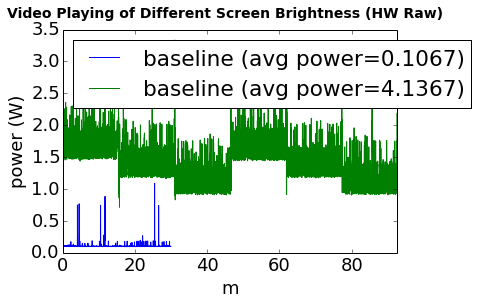

In [83]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1)
iaxes = iaxes2d

ifig.suptitle('Video Playing of Different Screen Brightness (HW Raw)', fontsize=14, fontweight='bold')
hw_df_baseline.plot(x='m', y='power', label='baseline (avg power=%s)'% round(baseline_power_mean,4), style='blue', ax=iaxes)
iaxes.set_ylabel("power (W)")
hw_df_video.plot(x='m', y='power', label='baseline (avg power=%s)'% round(video_power_mean,4), ax=iaxes, style="green")
ifig.savefig('quick_change_hw_validate_hw_raw_power.pdf')

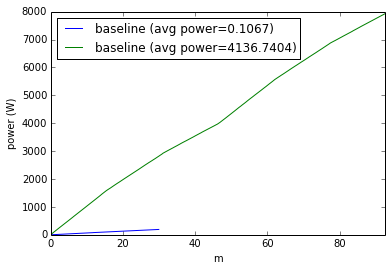

In [44]:
ax = hw_df_baseline.plot(x='m', y='cum_power', label='baseline (avg power=%s)'% round(baseline_power_mean,4), style='blue')
ax.set_ylabel("power (W)")
hw_df_video.plot(x='m', y='cum_power', label='baseline (avg power=%s)'% round(video_power_mean,4), ax=ax, style="green")

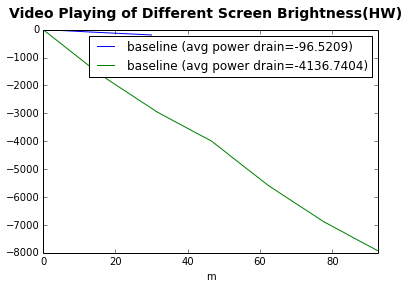

In [55]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1)
iaxes = iaxes2d

ifig.suptitle('Video Playing of Different Screen Brightness(HW)', fontsize=14, fontweight='bold')
hw_df_baseline.plot(x='m', y='cum_power_drain', label='baseline (avg power drain=%s)'% round(baseline_power_drain_mean,4), ax=iaxes,style='blue')
ax.set_ylabel("power (W)")
hw_df_video.plot(x='m', y='cum_power_drain', label='baseline (avg power drain=%s)'% round(video_power_drain_mean,4), ax=iaxes, style="green")
ifig.savefig('quick_change_hw_validate_hw_plot.pdf')

full discharge cycle: time       1798.000000
voltage    1794.304130
current    1797.971969
seconds    1798.000000
ts         1798.000000
power      1797.896401
hr         1798.000000
m          1798.000000
Name: 0, dtype: float64 seconds


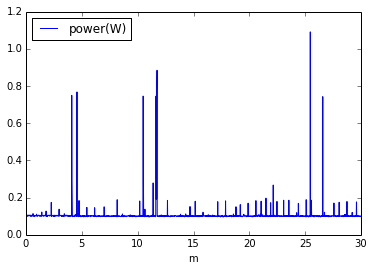

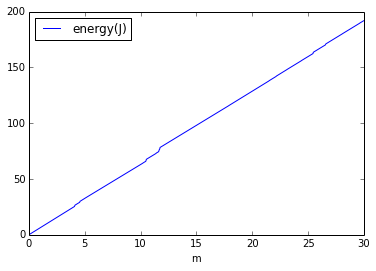

In [29]:
# integrate power to get energy 
from scipy import integrate

energy_baseline_series = integrate.cumtrapz(hw_df_baseline.power, hw_df_baseline.seconds, initial=0)

#plt.plot(power, energy, 'r-')
#plt.plot(x, y, 'b-')

diff = hw_df_baseline.seconds.iloc[-1] - hw_df_baseline.iloc[0]
print 'full discharge cycle: ' + str(diff) + ' seconds'
energy_baseline_df = pd.DataFrame(data={'ts': hw_df_baseline.seconds, 'm': hw_df_baseline.m, 'energy': energy_baseline_series})

hw_df_baseline.plot(x='m', y= 'power', label='power(W)')
energy_baseline_df.plot(x='m', y= 'energy', label='energy(J)')

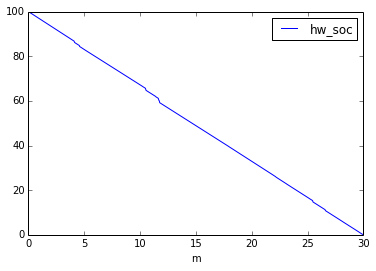

In [28]:
# calculate hw_soc from energy
max_cap = energy_baseline_series[-1]
energy_baseline_df['hw_soc'] = (max_cap - energy_baseline_df.energy)/max_cap*100
energy_baseline_df.plot(x='m', y='hw_soc')

In [74]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

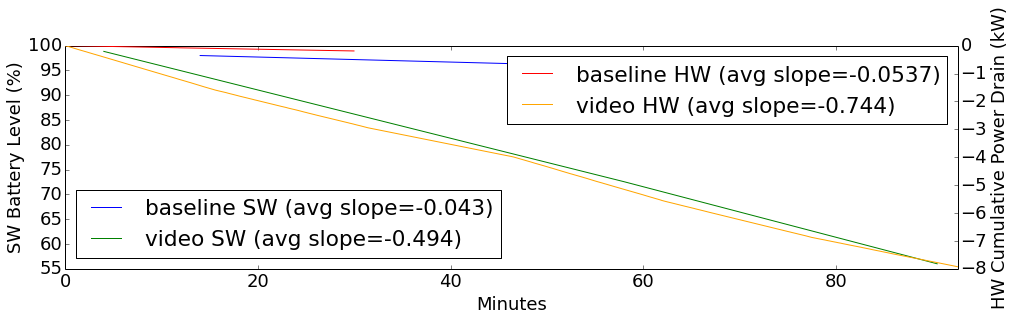

In [96]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,4))
iaxes = iaxes2d
iaxes2 = iaxes.twinx()

# ifig.suptitle('Video Playing of Different Screen Brightness', fontsize=14, fontweight='bold')

for i, df in enumerate(android_battery_interp_df_list):
    df['hr'] = (df.ts-time_list[i][0])/3600.0
    df['m'] = df.hr*60.0
    df.plot(x='m', y='battery_level_pct', style=style_interp[i], label=label[i]+" SW (avg slope=%s)" % round(slope_list[i], 3), ax=iaxes, legend=True)

hw_df_baseline.plot(x='m', y='cum_power_drain', label='baseline HW (avg slope=%s)'% round(baseline_power_drain_slope,4), ax=iaxes2,style='red')
hw_df_video.plot(x='m', y='cum_power_drain', label='video HW (avg slope=%s)'% round(video_power_drain_slope,4), ax=iaxes2, style="orange")
    
iaxes.set_xlabel('Minutes')
iaxes.set_ylabel('SW Battery Level (%)')
iaxes2.set_ylabel('HW Cumulative Power Drain (kW)')
ifig.savefig('../graphs/quick_change_hw_validate.pdf')

In [76]:
hw_df_baseline.plot(x='m', y='cum_power_drain', label='baseline HW (avg power drain=%s)'% round(baseline_power_drain_mean,4), ax=iaxes,style='blue')
ax.set_ylabel("power (W)")
hw_df_video.plot(x='m', y='cum_power_drain', label='video HW (avg power drain=%s)'% round(video_power_drain_mean,4), ax=iaxes, style="green")
# ifig.savefig('quick_change_hw_validate_hw_plot.pdf')

In [63]:
ifig.show()

/Users/shankari/OSS/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
